#Trabalho 2
RA217555 Gustavo Praciano Barros

RA217878 Hitalo Cesar Alves

##Divisão do trabalho

Cada membro ficou responsável por uma parte do trabalho, Gustavo(RA217555) ficou com a parte 1 e o Hitalo(RA21787) ficou com parte 2. Além disso, vale ressaltar que fizemos algumas análises e resoluções de problemas/bugs juntos, ou seja, mesmo com a divisão bem clara ainda colaboramos e fizemos como uma dupla.

##Importações

In [12]:
!pip install umap-learn[plot]

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
assert sklearn.__version__ >= "0.20"
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score, KFold
from sklearn import preprocessing
import umap.umap_ as umap

##Parte 1

###Funções de leitura

In [14]:
#Função para ler os dados do arquivo dat
def ReadDataEnun(fileName):
  datContent = np.array([i.strip().split() for i in open(fileName).readlines()])
  datContent = datContent.astype(np.float)
  return datContent

In [15]:
#Lendo os dados da parte 1
kick1 = ReadDataEnun("./kick1.dat")
kick2 = ReadDataEnun("./kick2.dat")

###Pré-processamento dos dados

In [16]:
#Pré-processamento dos dados
#Separando os dados de entrada e os resultados.

kick1 = kick1.T
results1 = np.array(kick1[len(kick1) - 1])
kick1 = np.delete(kick1, len(kick1) - 1, 0)
kick1 = kick1.T

kick2 = kick2.T
results2 = np.array(kick2[len(kick2) - 1])
kick2 = np.delete(kick2, len(kick2) - 1, 0)
kick2 = kick2.T

###Regressão linear

In [17]:
#Função para calcular a função custo.
def J(dados, pesos, results):
  m = len(dados)
  return sum([(np.dot(pesos,dados[i]) - results[i])**2 for i in range(0, len(dados))])/(2*m)   

In [18]:
#Função para calcular a derivada da função custo.
def DerivadaJ(dados, results, pesos, pos):
  m = len(dados)
  acum = 0
  for i in range(0,m):
     acum += (np.dot(pesos,dados[i]) - results[i]) * dados[i][pos]
  return acum/m

In [19]:
#Regressão Linear
def LinearReg(entrada, results, alpha, threshold, nEpocas):
  dados = np.copy(entrada)
  dados = dados.T
  #Acrescentando o valor '1' facilita o trabalho com a constante da regressão.
  dados = np.concatenate(([np.ones(len(dados[0]))], dados))
  dados = dados.T
  #Numero dos pesos.
  nConstantes = len(dados[0])
  #Inicialização com os valores '1'
  pesosTemp = np.array([1]*nConstantes).astype(float)
  pesos = np.array([1]*nConstantes).astype(float)
  #Custo de acordo com os pesos iniciais.
  j = J(dados, pesos, results)
  jTemp = 0
  #Calculei os tempos de execução caso precise.
  tempo0 = time.time()
  #Matriz com os dados para fazer análises.
  analiseEpocas = [[],[],[]]
  analiseEpocas[0].append(0)
  analiseEpocas[1].append(j)
  analiseEpocas[2].append(tempo0)
  for n in range(1, nEpocas + 1):
    for i in range(0, nConstantes):
        pesosTemp[i] = pesos[i] - alpha*DerivadaJ(dados, results, pesos, i)
    #Condição de parada e caso não, muda os valores. Jx-1 < Jx, para
    jTemp = J(dados, pesosTemp, results)
    #Caso o valor cresce, quebra o loop, geralmente isso ocorre quando o
    #alpha é muito grande.
    if( jTemp >= j):
        break
    j = jTemp
    #Substituindo os pesos.
    for i in range(0, nConstantes):
        pesos[i] = pesosTemp[i]
    if(n <= 100):
        analiseEpocas[0].append(n)
        analiseEpocas[1].append(j)
        analiseEpocas[2].append(time.time() - tempo0)
    #Caso já enonctrarmos um j bom para o problema, podemos parar o treinamento.
    if(j < threshold):
        break
  return pesos, np.array(analiseEpocas), j

In [20]:
#Função para aplicar os pesos da RL em um ponto
def AplicandoRL(ponto, pesos):
  aux = np.insert(ponto,0,1)
  return np.dot(pesos,aux)

###Regressão Polinomial

In [21]:
#Regressão polinomial
#Basicamente uma regressão linear com o pré-processamento, criando os valores com potência.
def PolinomialReg(entrada, results, alpha, grau, threshold, nEpocas):
  dados = np.copy(entrada)
  dados = dados.T
  n = len(dados[0])
  nFeatures = len(dados)
  #criando os valores elevados de acordo com o grau.
  for i in range(2,grau+1):
    for j in range(0, nFeatures):
      dados = np.concatenate((dados, np.array([np.power(dados[j],i)])))
  dados = dados.T
  #Chamando a regressão linear com os valores processados.
  return LinearReg(dados, results, alpha, threshold, nEpocas)

In [22]:
#Função para aplicar os pesos da RP em um ponto
def AplicandoRP(ponto, grau, pesos):
  aux = np.copy(ponto)
  nF = len(aux)
  for i in range(2,grau+1):
     aux = np.concatenate((aux, [aux[j]**i for j in range(0, nF)]))
  aux = np.insert(aux,0,1)
  return np.dot(pesos,aux)

OBS: O alpha na regressão polinomial é bem sensível às mudanças.

###Treinamento

####Funções para análisar o impacto do alpha

In [23]:
def TreinarRLComAnaliseDeAlphas(dados, resultados, alpha, threshold, nEpocas, titulo):
  tempo = time.time()
  pesos, analise1, j = LinearReg(dados, resultados, alpha, threshold, nEpocas)
  tempo = time.time() - tempo
  alphaE = alpha
  print("Para o alpha igual a " + str(alpha) +": j = " + str(j) + " , pesos = " + str(pesos) + "tempo: " + str(tempo))

  tempo = time.time()
  pesosAux, analise2, auxj = LinearReg(dados, resultados, alpha/2, threshold, nEpocas)
  tempo = time.time() - tempo
  print("Para o alpha igual a " + str(alpha/2) +": j = " + str(auxj) + " , pesos = " + str(pesosAux) + "tempo: " + str(tempo))
  if(j > auxj):
    alphaE = alpha/2
    j = auxj
    pesos = pesosAux

  tempo = time.time()
  pesosAux, analise3, auxj = LinearReg(dados, resultados, alpha/4, threshold/4, nEpocas)
  tempo = time.time() - tempo
  print("Para o alpha igual a " + str(alpha/4) +": j = " + str(auxj) + " , pesos = " + str(pesosAux) + "tempo: " + str(tempo))
  if(j > auxj):
    alphaE = alpha/4
    j = auxj
    pesos = pesosAux

  print("Menor custo final de " + str(j) + "do treinamento com o alpha " + str(alphaE))
  print("Pesos escolhido: " + str(pesos))

  plt.title("Learning rate para " + titulo + " regressão linear")
  plt.xlabel('Numero de épocas')
  plt.ylabel('Custo')

  x = analise1[0]
  y = analise1[1]
  plt.plot(x, y, label = str(alpha))

  x = analise2[0]
  y = analise2[1]
  plt.plot(x, y, color = "red", label = str(alpha/2))

  x = analise3[0]
  y = analise3[1]
  plt.plot(x, y, color = "green", label = str(alpha/4))

  plt.show()
  return pesos

In [24]:
def TreinarRPComAnaliseDeAlphas(dados, resultados, alpha, grau, threshold, nEpocas, titulo):
  tempo = time.time()
  pesos, analise1, j = PolinomialReg(dados, resultados, alpha, grau, threshold, nEpocas)
  tempo = time.time() - tempo
  alphaE = alpha
  print("Para o alfha igual a " + str(alpha) +": j = " + str(j) + " , pesos = " + str(pesos) + "tempo: " + str(tempo))

  tempo = time.time()
  pesosAux, analise2, auxj = PolinomialReg(dados, resultados, alpha/2, grau, threshold, nEpocas)
  tempo = time.time() - tempo
  print("Para o alpha igual a " + str(alpha/2) +": j = " + str(auxj) + " , pesos = " + str(pesosAux) + "tempo: " + str(tempo))
  if(j > auxj):
    alphaE = alpha/2
    j = auxj
    pesos = pesosAux

  tempo = time.time()
  pesosAux, analise3, auxj = PolinomialReg(dados, resultados, alpha/4, grau, threshold/4, nEpocas)
  tempo = time.time() - tempo
  print("Para o alpha igual a " + str(alpha/4) +": j = " + str(auxj) + " , pesos = " + str(pesosAux) + "tempo: " + str(tempo))
  if(j > auxj):
    alphaE = alpha/4
    j = auxj
    pesos = pesosAux

  print("Menor custo final de " + str(j) + "do treinamento com o alpha " + str(alphaE))
  print("Pesos escolhido: " + str(pesos))

  plt.title("Learning rate para " + titulo + " regressão polinomial grau " + str(grau))
  plt.xlabel('Numero de épocas')
  plt.ylabel('Custo')

  x = analise1[0]
  y = analise1[1]
  plt.plot(x, y, label = str(alpha))

  x = analise2[0]
  y = analise2[1]
  plt.plot(x, y, color = "red", label = str(alpha/2))

  x = analise3[0]
  y = analise3[1]
  plt.plot(x, y, color = "green", label = str(alpha/4))

  plt.show()
  return pesos

####Treinamento e análise dos alphas

Nas células abaixo coloquei os pesos finais encontrados no comentário, caso não queira fazer o treinamento que é um pouco demorado, pode só atribuir os valores nos respectivos pesos.

Para o alpha igual a 0.45: j = 9.732221074496973e-05 , pesos = [ 0.08967609 -0.00632614  0.01605979]tempo: 19.714582681655884
Para o alpha igual a 0.225: j = 9.745160382959264e-05 , pesos = [0.12600176 0.00945059 0.00030465]tempo: 19.640774726867676
Para o alpha igual a 0.1125: j = 9.958184430220735e-05 , pesos = [ 0.24826424  0.06255085 -0.05272291]tempo: 19.690383195877075
Menor custo final de 9.732221074496973e-05do treinamento com o alpha 0.45
Pesos escolhido: [ 0.08967609 -0.00632614  0.01605979]


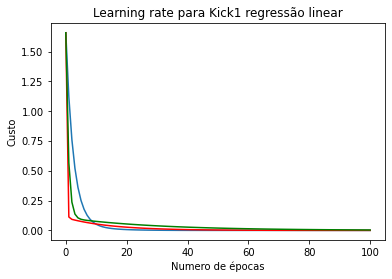

[ 0.08967609 -0.00632614  0.01605979]


In [25]:
#Treinamento Kick1 regressão linear
pesos1 = TreinarRLComAnaliseDeAlphas(kick1, results1, 0.45, 0.000001, 100000, "Kick1")
#pesos1 = [ 0.08967609, -0.00632614,  0.01605979]
print(pesos1)

Para o alpha igual a 0.4: j = 0.0001275829253444912 , pesos = [ 0.06909373 -0.35383801  0.02549296]tempo: 19.67229151725769
Para o alpha igual a 0.2: j = 0.00012857394773573222 , pesos = [ 0.15493841 -0.27869305 -0.01163801]tempo: 19.61909508705139
Para o alpha igual a 0.1: j = 0.0001367046693163064 , pesos = [ 0.34949848 -0.10838304 -0.09579238]tempo: 19.53451943397522
Menor custo final de 0.0001275829253444912do treinamento com o alpha 0.4
Pesos escolhido: [ 0.06909373 -0.35383801  0.02549296]


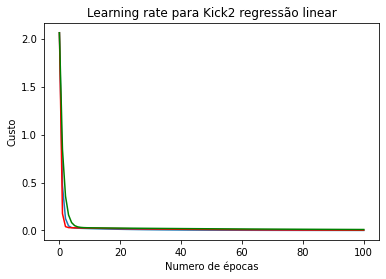

[ 0.06909373 -0.35383801  0.02549296]


In [26]:
#Treinamento Kick2 regressão linear
pesos2 = TreinarRLComAnaliseDeAlphas(kick2, results2, 0.4, 0.000001, 100000, "Kick2")
#pesos2 = [ 0.06909373, -0.35383801,  0.02549296]
print(pesos2)

Para o alfha igual a 0.1: j = 9.645547524544335e-05 , pesos = [-0.06864748  0.25398835  0.36251631  0.16651885 -0.116931  ]tempo: 29.580485343933105
Para o alpha igual a 0.05: j = 0.00012236111888949764 , pesos = [ 0.153377    0.49643516  0.42922805  0.22309535 -0.18909005]tempo: 29.574583768844604
Para o alpha igual a 0.025: j = 0.0001694343049393263 , pesos = [ 0.37845634  0.73011626  0.48421149  0.27538078 -0.25670093]tempo: 29.545389413833618
Menor custo final de 9.645547524544335e-05do treinamento com o alpha 0.1
Pesos escolhido: [-0.06864748  0.25398835  0.36251631  0.16651885 -0.116931  ]


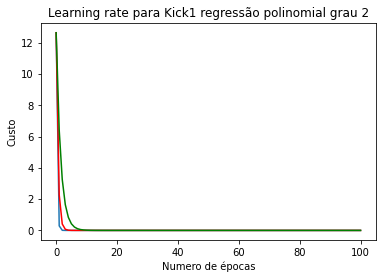

[-0.06864748  0.25398835  0.36251631  0.16651885 -0.116931  ]


In [27]:
#Treinamento Kick1 regressão polinomial de grau2
pesosP1 = TreinarRPComAnaliseDeAlphas(kick1, results1, 0.1, 2, 0.000001, 100000, "Kick1")
#pesosP1 = [-0.06864748,  0.25398835,  0.36251631,  0.16651885, -0.116931  ]
print(pesosP1)

Para o alfha igual a 0.1: j = 8.969132632728513e-05 , pesos = [ 0.02107105  0.57041581  0.69718103  0.55203642 -0.29559284]tempo: 29.400309801101685
Para o alpha igual a 0.05: j = 0.00011197587651969947 , pesos = [ 0.22474738  0.81652732  0.64293724  0.61139159 -0.31029802]tempo: 29.53997826576233
Para o alpha igual a 0.025: j = 0.00013662182314160286 , pesos = [ 0.38170097  0.98811114  0.57937403  0.66384253 -0.31122511]tempo: 29.47152352333069
Menor custo final de 8.969132632728513e-05do treinamento com o alpha 0.1
Pesos escolhido: [ 0.02107105  0.57041581  0.69718103  0.55203642 -0.29559284]


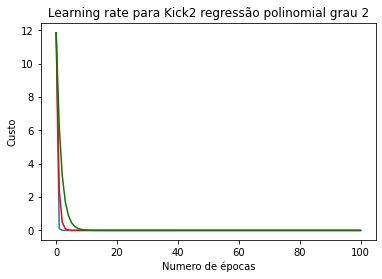

[ 0.02107105  0.57041581  0.69718103  0.55203642 -0.29559284]


In [28]:
#Treinamento Kick2 regressão polinomial de grau 2
pesosP2 = TreinarRPComAnaliseDeAlphas(kick2, results2, 0.1, 2, 0.000001, 100000, "Kick2")
#pesosP2 = [ 0.02107105,  0.57041581,  0.69718103,  0.55203642, -0.29559284]
print(pesosP2)

Para o alfha igual a 0.05: j = 0.00010068934434139963 , pesos = [ 1.56163278e-01  6.86832996e-01  4.23745688e-04  9.80540278e-01
  8.96836698e-02  4.07978750e-01 -3.21259703e-02]tempo: 79.01062297821045
Para o alpha igual a 0.025: j = 0.00011478938972508848 , pesos = [ 0.25851713  0.86227883  0.06921701  1.10641361  0.02688921  0.45740585
 -0.02541553]tempo: 78.92159152030945
Para o alpha igual a 0.0125: j = 0.00013223860868382835 , pesos = [ 0.37178531  1.00900354  0.12741251  1.15517518 -0.02387733  0.4653457
 -0.02383786]tempo: 78.73768949508667
Menor custo final de 0.00010068934434139963do treinamento com o alpha 0.05
Pesos escolhido: [ 1.56163278e-01  6.86832996e-01  4.23745688e-04  9.80540278e-01
  8.96836698e-02  4.07978750e-01 -3.21259703e-02]


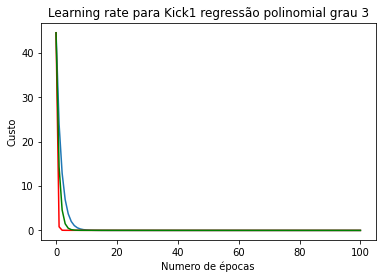

[ 1.56163278e-01  6.86832996e-01  4.23745688e-04  9.80540278e-01
  8.96836698e-02  4.07978750e-01 -3.21259703e-02]


In [29]:
#Treinamento Kick1 regressão polinomial de grau 3
pesosP1grau3 = TreinarRPComAnaliseDeAlphas(kick1, results1, 0.05, 3, 0.000001, 200000, "Kick1")
#pesosP1grau3 = [ 1.56163278e-01,  6.86832996e-01,  4.23745688e-04,  9.80540278e-01, 8.96836698e-02,  4.07978750e-01, -3.21259703e-02]
print(pesosP1grau3)

Para o alfha igual a 0.04: j = 8.9787569506746e-05 , pesos = [ 0.41732736  0.75150162  0.18705267  1.19400637 -0.06665813  0.90748133
 -0.03450139]tempo: 39.48474597930908
Para o alpha igual a 0.02: j = 0.00010375334459224238 , pesos = [ 0.51782673  0.87302089  0.1979311   1.17181051 -0.10562626  0.88126878
 -0.0279719 ]tempo: 39.383740186691284
Para o alpha igual a 0.01: j = 0.00011440601329403809 , pesos = [ 0.5815974   0.94634114  0.2055926   1.15489802 -0.1319446   0.86994825
 -0.02329178]tempo: 39.28790330886841
Menor custo final de 8.9787569506746e-05do treinamento com o alpha 0.04
Pesos escolhido: [ 0.41732736  0.75150162  0.18705267  1.19400637 -0.06665813  0.90748133
 -0.03450139]


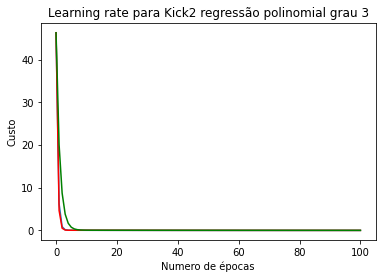

[ 0.41732736  0.75150162  0.18705267  1.19400637 -0.06665813  0.90748133
 -0.03450139]


In [30]:
#Treinamento Kick2 regressão polinomial de grau 3
pesosP2grau3 = TreinarRPComAnaliseDeAlphas(kick2, results2, 0.04, 3, 0.000001, 100000, "Kick2")
#pesosP2grau3 = [ 0.41732736,  0.75150162,  0.18705267,  1.19400637, -0.06665813,  0.90748133, -0.03450139]
print(pesosP2grau3)

  Inicialmente, gostaria de dizer como encontrei os alphas empiricamente, quando o alpha é muito grande para o problema, o custo aumenta, assim o treinamento acaba com os pesos iniciais. Pensando nisso, fui diminuindo os alphas até encontrar alphas que convergem no treinamento.

  Vou ressaltar 3 pontos principais nessa análise. Primeiro, dos 3 alphas analisados em cada caso, todos com maior valor tiveram um resultado final melhor, isso ocorre porque após convergir no treinamento, as mudanças no custo são muito pequenas, mas se o alpha for maior, essas pequenas mudanças acabam sendo maiores também e deixando o valor de custo próóximo de 0 de forma mais rapida.

  Segundo ponto, ainda similar com o ponto anterior, os alphas os maiores convergem mais rápido no treinamento, das 6 análises feitas 5 tiveram esse comportamento, o caso especial vou tratar melhor depois, esse comportamento ocorre similar com a explicação anterior, o alpha maior tem uma taxa de decerescimento maior. E o terceiro ponto; no treinamento 1 e 5, conseguimos ver que a linha azul, a qual representa do maior alpha, demorar para convergir, isso ocorre porque o alpha apesar de convergir após algumas intereções, é grande o suficiente para oscilar na função custo até um momento, começar a decrescer diretamente para o mínimo e convergir. O interessante disso que o alpha maior continua tendo melhor resultado, pois mesmo com esse efeito o alpha maior ainda converge assim ocorrendo o que foi explicitado anteriormente.

###Predições das tragetórias

####Encontrando os coeficientes de reta em XY

Essa parte encontrei quais seriam as retas dos pontos em XY na trajetória da bola considerando que após o chute do jogador, a trajetória em XY não mudaria, o que mudaria seria a altura de acordo com a forma que o jogador chutou. Para encontrar as retas, basicamente foi desenvolvida uma equação da reta com os pontos extremos do dataset.

OBS: Isso é uma situação hipótetica, claro que se fosse uma simulação mais detalhada teríamos que pensar em outros fatores como vento, efeito magnus, etc.

[-0.21  -0.305 -0.368 -0.37  -0.48  -0.532 -0.575 -0.583 -0.618 -0.702
 -0.783 -0.842 -0.882 -0.93  -0.969 -0.989 -1.032 -1.088 -1.104 -1.192]
[2.048 1.999 1.968 1.902 1.841 1.807 1.733 1.69  1.649 1.611 1.568 1.523
 1.438 1.408 1.34  1.295 1.244 1.201 1.159 1.109]


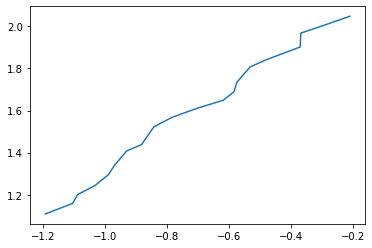

In [31]:
kick1 = kick1.T
x = kick1[0]
y = kick1[1]
kick1 = kick1.T

plt.plot(x, y)

print(x)
print(y)

plt.show()

#ponto0 = (-1,192: 1.109)
#ponte1 = (-0.21, 2.048)

[-0.105 -0.162 -0.184 -0.185 -0.23  -0.266 -0.287 -0.311 -0.309 -0.331
 -0.391 -0.431 -0.441 -0.445 -0.484 -0.514 -0.516 -0.524 -0.552 -0.596]
[2.048 1.999 1.968 1.902 1.841 1.807 1.733 1.69  1.649 1.611 1.568 1.523
 1.438 1.408 1.34  1.295 1.244 1.201 1.159 1.109]


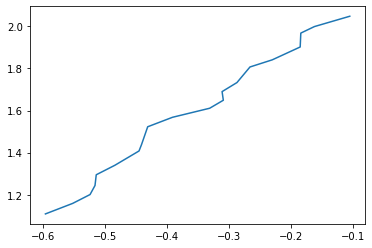

In [32]:
kick2 = kick2.T
x = kick2[0]
y = kick2[1]
kick2 = kick2.T

plt.plot(x, y)

print(x)
print(y)

plt.show()

#ponto0 = [-0.596, 1.109]
#ponto1 = [-0.105, 2.048]

In [33]:
#kick1
ponto0 = [-1.192, 1.109]
ponto1 = [-0.21, 2.048]

m1 = (ponto1[1] - ponto0[1])/(ponto1[0] - ponto0[0])
m01 = ponto0[1] - m1*ponto0[0]

#kick2
ponto0 = [-0.596, 1.109]
ponto1 = [-0.105, 2.048]

m2 = (ponto1[1] - ponto0[1])/(ponto1[0] - ponto0[0])
m02 = ponto0[1] - m2*ponto0[0]

print(m1, m01)
print(m2, m02)

0.9562118126272913 2.248804480651731
1.9124236252545825 2.248804480651731


####Plot das predições dos chutes

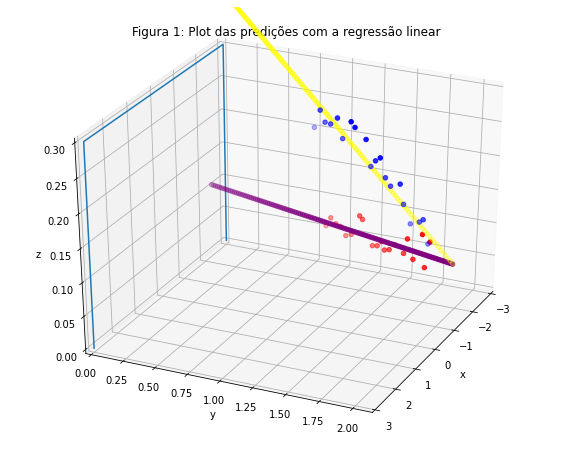

In [34]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.set_xlim([-3, 3])
ax.set_ylim([0, 2.1])
ax.set_zlim([0, 0.3])

ax.set_title("Figura 1: Plot das predições com a regressão linear")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

kick1 = kick1.T
x, y, z = kick1[0], kick1[1], results1
kick1 = kick1.T
ax.scatter(x,y,z, color = 'red')

kick2 = kick2.T
x, y, z = kick2[0], kick2[1], results2
kick2 = kick2.T
ax.scatter(x,y,z, color = 'blue')

x = np.linspace(-m01/m1, 0, 120)
y = m1*x + m01
z = np.array([AplicandoRL([x[i], y[i]], pesos1) for i in range(0, len(x))])
ax.scatter(x,y,z, color = 'purple')

x = np.linspace(-m02/m2, 0, 120)
y = m2*x + m02
z = np.array([AplicandoRL([x[i], y[i]], pesos2) for i in range(0, len(x))])
ax.scatter(x,y,z, color = 'yellow')

ax.plot([-3,-3,3,3],[0,0,0,0],[0,0.3,0.3,0])

ax.view_init(30, 25)

plt.show()

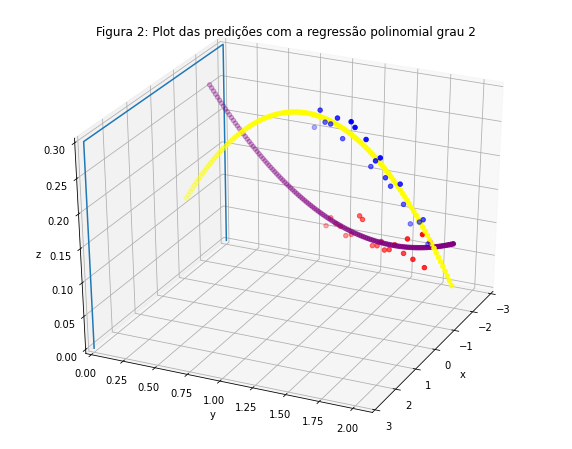

In [35]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.set_xlim([-3, 3])
ax.set_ylim([0, 2.1])
ax.set_zlim([0, 0.3])

ax.set_title("Figura 2: Plot das predições com a regressão polinomial grau 2")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

kick1 = kick1.T
x, y, z = kick1[0], kick1[1], results1
kick1 = kick1.T
ax.scatter(x,y,z, color = 'red')

kick2 = kick2.T
x, y, z = kick2[0], kick2[1], results2
kick2 = kick2.T
ax.scatter(x,y,z, color = 'blue')

x = np.linspace(-m01/m1, 0, 120)
y = m1*x + m01
z = np.array([AplicandoRP([x[i], y[i]], 2, pesosP1) for i in range(0, len(x))])
ax.scatter(x,y,z, color = 'purple')

x = np.linspace(-m02/m2, 0, 120)
y = m2*x + m02
z = np.array([AplicandoRP([x[i], y[i]], 2, pesosP2) for i in range(0, len(x))])
ax.scatter(x,y,z, color = 'yellow')

ax.plot([-3,-3,3,3],[0,0,0,0],[0,0.3,0.3,0])

ax.view_init(30, 25)

plt.show()

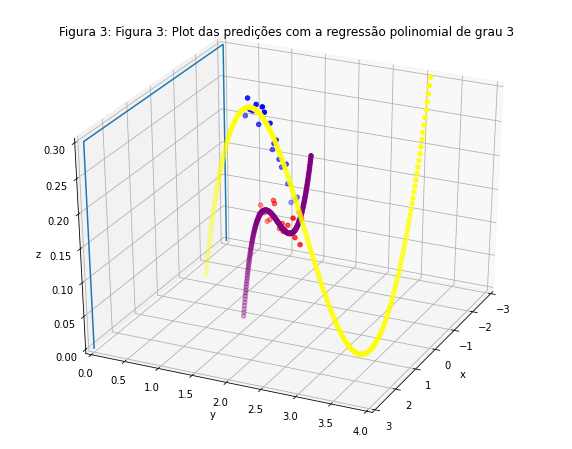

In [36]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.set_xlim([-3, 3])
ax.set_ylim([0, 4])
ax.set_zlim([0, 0.3])

ax.set_title("Figura 3: Figura 3: Plot das predições com a regressão polinomial de grau 3")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

kick1 = kick1.T
x, y, z = kick1[0], kick1[1], results1
kick1 = kick1.T
ax.scatter(x,y,z, color = 'red')

kick2 = kick2.T
x, y, z = kick2[0], kick2[1], results2
kick2 = kick2.T
ax.scatter(x,y,z, color = 'blue')

x = np.linspace(-1.6, 0, 200)
y = m1*x + m01
z = np.array([AplicandoRP([x[i], y[i]], 3, pesosP1grau3) for i in range(0, len(x))])
ax.scatter(x,y,z, color = 'purple')

x = np.linspace(-1, 1, 300)
y = m2*x + m02
z = np.array([AplicandoRP([x[i], y[i]], 3, pesosP2grau3) for i in range(0, len(x))])
ax.scatter(x,y,z, color = 'yellow')

ax.plot([-3,-3,3,3],[0,0,0,0],[0,0.3,0.3,0])

ax.view_init(30, 25)

plt.show()

  Analisando as complexidades dos modelos, conseguimos observar bem o que foi apresentado em aula sobre a necessidade de treinar um modelo complexo o suficiente para os dados e o problema. Todos os treinamento deram certo, encontramos pesos e os treinamentos convergiram. Mas isso não é sinônimo que o resultado é de qualidade. Um exemplo claro disso é a regressão polinomial de grau 3, conseguimos encontrar um comportamento para os dados, mas claramente não representa um chute de uma bola, se forçarmos um pouco, talvez poderíamos usar para representar a bola quicando, mas um chute direto ao gol fisicamente não faz sentido. Outros exemplos que a complexidade não condiz com o problema, é a polinomial de grau 2 do kick1 e a linear do kick2, isso porque ambos mostram um comprotamento irreal também, respectivamente, a bola não pode começar a subir sem força externa de um jogador, e a bola não pode ficar infinitamente subindo devido a gravidade.

  No geral, os modelos que melhor representam nossos chutes são a regressão linear do kick1 e a polinomial de grau 2 do kick2, pois ambas se mostram coerentes com a física e o ambiente controlado de um chute. Vale ressaltar que apesar de estarmos generelizando como um chute, o kick 1 e um kick2 podem ser tratados como problemas diferentes, pois um chute rasteiro tem um comportamento diferente que um chute alto.

Agora vamos análisar se o goleiro defenderia. Primeiramente, se o goleiro não tiver um treinamento adequado, independentemente da capacidade de defender o gol ou não, ele movimentaria de forma inadequada, por isso vou supor que o goleiro reconhece quando usar regressão linear para um chute rasteiro e regressão polinomial de grau 2 para um chute alto. Dessa forma, a análise se limita nos dois modelos bons que mencionei na célula anterior.

Sabemos que os dados são lidos em 60 frames por segundo, na simulação do meu chute coloquei 120 pontoas da trajetória, vou supor que cada frame é um ponto, assim o evento do chute até chegar no gol seria de 2 segundos. O robô demora 1/3 s para decidir seu movimento de acordo com a trajatéria, se ele se move instantanimente para a posição que a bola entra no gol, ele defende todas. Para ficar mais interessante o exemplo, vamos supor que o robô se mexe com uma velocidade constante de 1m/s e tem a altura da metade do gol. Após sua decisão ele tem 1.6(2 - 1/3) para se movimentar, assim os chutes que estão a 1.6 ou menos de distância do ponto zero(onde ele se posiciona inicialmente)  ele consegue agarrar. Ambos os chutes 1 e 2 chegam a uma altura menos que a metade do gol, ou seja, o goleiro alcança se estiver na posição certa. Pensando nesses dados, o goleiro conseguiria agarrar o chute 2 porque onde a posição final do da bola no gol tem a coordenada y menor que 1.6. Também podemos inferir que ele não consegueria agarrar o chute 1 pois o a coordenada y do chute1 é maior que 1.6.

## Parte 2

### Carregamento de dados

In [37]:
def plotNumbers(data, label):
  sns.set(context="paper", style="white")
  reducer = umap.UMAP(random_state=42)
  embedding = reducer.fit_transform(data)
  print(embedding.shape)

  fig, ax = plt.subplots(figsize=(12, 10))
  color = {0:"blue", 1:"green", 2:"black", 3:"brown", 4:"red", 5:"yellow", 6:"purple", 7:"pink", 8:"grey", 9:"violet"}
  colors = [color[label.iloc[i]["out"]] for i in range(len(label)) ]
  plt.scatter(embedding[:,0], embedding[:,1], c=colors, cmap="Spectral", s=3)
  plt.setp(ax, xticks=[], yticks=[])
  plt.title("data embedded into two dimensions by UMAP", fontsize=18)

  plt.show()


#### Load dataset direto da fonte
Como descrito no link http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits é possível fazer o download do dataset original com os dados representados como na descrição apresentada no proprio endereço. Nesse dataset temos cerca de 11000 amostras que estão separadas em 70% para treninamento e 30% para teste com 16 dimensões representando (x_t,y_t) para 8 tempos diferentes escolhidos de forma uniforme no espaço e/ou no tempo. Também foi feita uma união dos datasets e uma nova separação em 90/10 - treinamento/teste.

In [38]:
dfTrainSource = pd.read_csv("https://raw.githubusercontent.com/HitaloCesar/MC886/master/trabalho2/pendigits.tra", sep=',', names=["a", "b", "c", "d", "e", "f",
                                                                                                                           "g","h","i","j", "k", "l", "m", "n", "o","p", "out"])
dfTestSource = pd.read_csv("https://raw.githubusercontent.com/HitaloCesar/MC886/master/trabalho2/pendigits.tes", sep=',', names=["a", "b", "c", "d", "e", "f",
                                                                                                                           "g","h","i","j", "k", "l", "m", "n", "o","p", "out"])

x = dfTrainSource.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfTrainSource = pd.DataFrame(x_scaled)
dfTrainSource.columns= ["a", "b", "c", "d", "e", "f", "g","h","i","j", "k", "l", "m", "n", "o","p", "out"]

x = dfTestSource.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfTestSource = pd.DataFrame(x_scaled)
dfTestSource.columns= ["a", "b", "c", "d", "e", "f", "g","h","i","j", "k", "l", "m", "n", "o","p", "out"]

print("Train source shape = "+str(dfTrainSource.shape))
print("Test source shape = "+str(dfTestSource.shape))

dfEnd = pd.concat([dfTrainSource, dfTestSource])
print("End source shape = "+str(dfEnd.shape))

msk = np.random.rand(len(dfEnd)) < 0.9

dfTrain = dfEnd[msk]
dfTest = dfEnd[~msk]

print("Train final shape = "+str(dfTrain.shape))
print("Test final shape = "+str(dfTest.shape))


Train source shape = (7494, 17)
Test source shape = (3498, 17)
End source shape = (10992, 17)
Train final shape = (9937, 17)
Test final shape = (1055, 17)


In [39]:
dfTrainLabel = dfTrain[["out"]]*9
dfTrainLabel = dfTrainLabel.astype(int)
dfTrainData = dfTrain[["a", "b", "c", "d", "e", "f","g","h","i","j", "k", "l", "m", "n", "o","p"]]

dfTestLabel = dfTest[["out"]]*9
dfTestLabel = dfTestLabel.astype(int)
dfTestData = dfTest[["a", "b", "c", "d", "e", "f","g","h","i","j", "k", "l", "m", "n", "o","p"]]

print(dfTrainLabel.shape)
print(dfTrainData.shape)

print(dfTestLabel.shape)
print(dfTestData.shape)

(9937, 1)
(9937, 16)
(1055, 1)
(1055, 16)


(9937, 2)


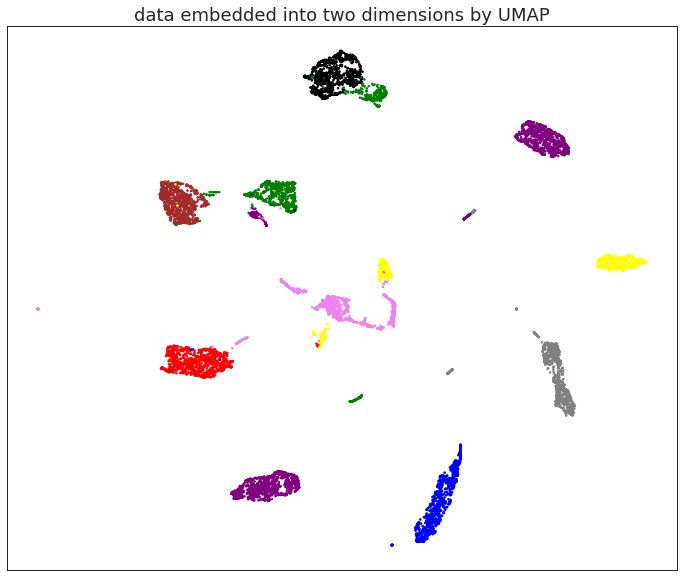

In [40]:
plotNumbers(dfTrainData, dfTrainLabel)

(1055, 2)


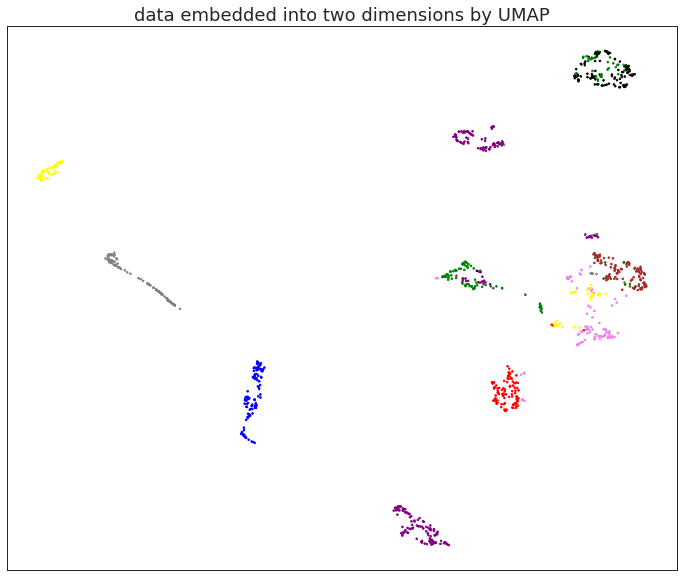

In [41]:
plotNumbers(dfTestData, dfTestLabel)

#### Load dataset usando sklearn
Foi feito um load dos dados utilizando do sklearn também, mas como o dataset do sklearn possui uma quantidade menor de amostras, optamos por usar os dados baixados direto da fonte mesmo, pois com eles temos mais liberdade para fazer o tratamento e as analises. Mas também faremos um teste com o melhor dos modelos no dataset do sklearn.

In [42]:
digits = datasets.load_digits()

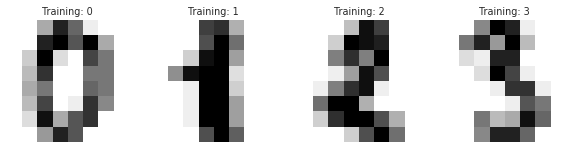

In [43]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [44]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [45]:
dfTrainDataSK, dfTestDataSK, dfTrainLabelSK, dfTestLabelSK = train_test_split(
    data, digits.target, test_size=0.1, shuffle=False)

### Treinamento modelos

In [46]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)

#### Modelo 1
Regressão logistica com cross-validation. No sklearn, existe uma classe de regressão logística onde ela já é feita utilizando de cross validation, sendo necessário assim apenas passar o argumento cv que é a divisão com a qual será feita o cross-validation. No caso optamos por utilizar um 5-fold para todos os modelos.

In [47]:
model1 = LogisticRegressionCV(max_iter=2000, solver="liblinear", cv = kf)
model1.fit(dfTrainData, dfTrainLabel.values.ravel())

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=KFold(n_splits=5, random_state=42, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=2000, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='liblinear', tol=0.0001, verbose=0)

#### Modelo 2
Modelo de maquina de vetores de suporte C(onde C é o parametro de regularização entre 0 e 1) utilizando cross validation. Com o auxilio da cross-validation, foi feito um gráfico de modo a determinar o valor de C. Vale observar que caso o parametro probability do modelo seja true, ele usa um 5-fold internamente durante o treinamento, mas não exatamente para encontrar o C. Optamos por fazer isso de forma um pouco mais manual para podermos observar no gráfico como varia o score em função do C.(por algum motivo a celula seguinte não funciona bem com o run all).

[1.00000000e-10 1.29154967e-09 1.66810054e-08 2.15443469e-07
 2.78255940e-06 3.59381366e-05 4.64158883e-04 5.99484250e-03
 7.74263683e-02 1.00000000e+00]
[0.19265594 0.19818913 0.20181178 0.20080523 0.20181178]
[0.19265594 0.19818913 0.20181178 0.20080523 0.20181178]
[0.19265594 0.19818913 0.20181178 0.20080523 0.20181178]
[0.19265594 0.19818913 0.20181178 0.20080523 0.20181178]
[0.19265594 0.19818913 0.20181178 0.20080523 0.20181178]
[0.19265594 0.19818913 0.20181178 0.20080523 0.20181178]
[0.19265594 0.19818913 0.20181178 0.20080523 0.20181178]
[0.8445674  0.85261569 0.84499245 0.84146955 0.84599899]
[0.94517103 0.93812877 0.94514343 0.93608455 0.93960745]
[0.97434608 0.97283702 0.97181681 0.970307   0.96829391]


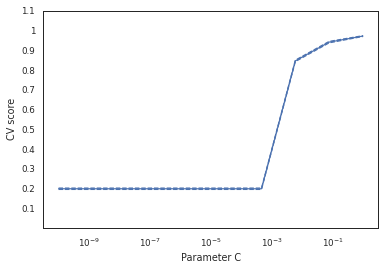

In [48]:
model2 = SVC(kernel = 'linear', max_iter=2000, probability=False)

Cs = np.logspace(-10, 0, 10)
print(Cs)
scores = list()
scores_std = list()
for C in Cs:
    model2.C = C
    this_scores = cross_val_score(model2, dfTrainData, dfTrainLabel.values.ravel(), cv = kf)
    print(this_scores)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure()
plt.semilogx(Cs, scores)
plt.semilogx(Cs, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(Cs, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()




Como observado no gráfico, utilizaremos C=1.

In [49]:
model2 = SVC(kernel = 'linear', max_iter=2000, probability=False, C=1)
model2.fit(dfTrainData, dfTrainLabel.values.ravel())

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=2000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Modelo 3
Arvore de tomada de decisão utilizando cross-validation como uma ferramenta para o auxilio na escolha da altura máxima da árvore. Na celula seguinte, é feito o experimento de modo a apresentar o gráfico da acuracia em função da altura máxima.

Average score(1): 0.257
Average score(2): 0.450
Average score(3): 0.603
Average score(4): 0.769
Average score(5): 0.854
Average score(6): 0.894
Average score(7): 0.932
Average score(8): 0.947
Average score(9): 0.954
Average score(10): 0.958
Average score(11): 0.960
Average score(12): 0.960
Average score(13): 0.960
Average score(14): 0.960
Average score(15): 0.961
Average score(16): 0.961
Average score(17): 0.960
Average score(18): 0.960
Average score(19): 0.960
Average score(20): 0.960
Average score(21): 0.960
Average score(22): 0.960
Average score(23): 0.960
Average score(24): 0.960
Average score(25): 0.960
Average score(26): 0.960
Average score(27): 0.960
Average score(28): 0.960
Average score(29): 0.960


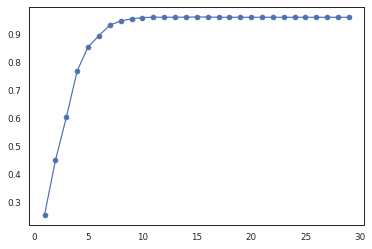

In [50]:
xAux = []
yAux = []
for maxDepth in range(1,30):
    score = cross_val_score(tree.DecisionTreeClassifier(max_depth= maxDepth, random_state= 42), dfTrainData, dfTrainLabel.values.ravel(), cv= kf, scoring="accuracy")
    print(f'Average score({maxDepth}): {"{:.3f}".format(score.mean())}')
    xAux.append(maxDepth)
    yAux.append(score.mean())
plt.scatter(xAux, yAux)
plt.plot(xAux, yAux)

Como observado no gráfico, em torno da altura maxima 11 se começa a estabilizar o score e em 13 se alcança essa estabilização quase que completa. Então utilizaremos a altura maxima como 13.

In [51]:
maxDepth = 13
model3 = tree.DecisionTreeClassifier(max_depth= maxDepth)
model3.fit(dfTrainData, dfTrainLabel.values.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Aplicação dos modelos nos conjuntos de testes
Para validar os testes, como se trata de um modelo onde o objetivo é apenas identificar os números e não se sabe a priori se é necessário se preocupar mais com falsos positivos ou falsos negativos, a métrica utilizada para avaliar os modelos foi a acurácia. Mesma metrica utilizada inclusive durante parte do treinamento para se avaliar os scores e escolher parametros.

In [52]:
def testModel(model):
  resultTest = model.predict(dfTestData)
  score = model.score(dfTestData, dfTestLabel)
  return score, resultTest


In [53]:
score1, resultTest1 = testModel(model1)
score2, resultTest2 = testModel(model2)
score3, resultTest3 = testModel(model3)


In [54]:
cm1 = metrics.confusion_matrix(dfTestLabel, resultTest1)
cm2 = metrics.confusion_matrix(dfTestLabel, resultTest2)
cm3 = metrics.confusion_matrix(dfTestLabel, resultTest3)


In [55]:

def confusionMatrix(cm, accuracy, title):
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = title+': {0}'.format(accuracy)
  plt.title(all_sample_title, size = 15);
  plt.show();



#### Regressão Logistica

Nesse modelo podemos observar uma acuracia bastante consistente. As maiores dificuldades do algoritmo se dão por confundir o 1 com o 5(não o 5 com o 1). Isso pode se dar devido à forma a qual a regressão logistica é construída fazendo uma classificação um tanto quanto binaria na separação, trazendo esses efeitos.

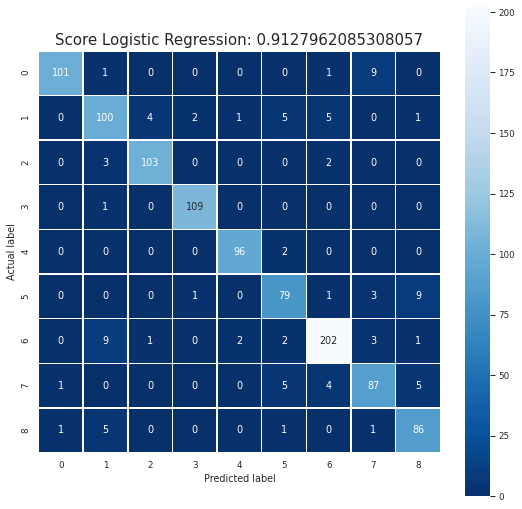

In [56]:
confusionMatrix(cm1, score1, "Score Logistic Regression")

#### SVC
Essa abordagem apresenta resultado muito bom como pode ser observado na matriz de confusão e no valor da acuracia. A maior dificuldade do modelo aparentemente se apresenta em confundir o 7 com o 0(com 3 falsos 0's detectados). Ao olhar humano esses digitos são bastante diferentes, porém para o modelo eles se apresentam semelhantes.

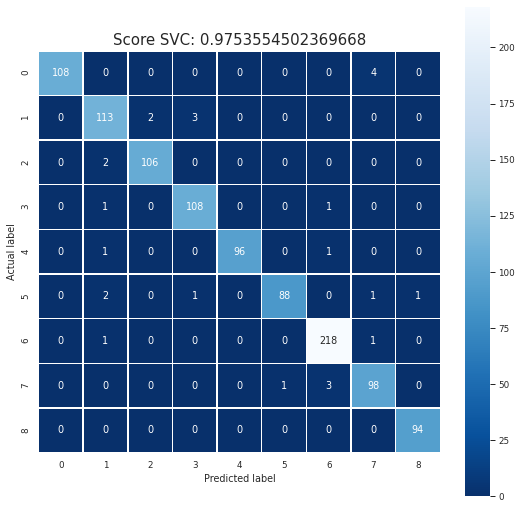

In [57]:
confusionMatrix(cm2, score2, "Score SVC")

#### Arvore de decisão

A arvore de decisão apresenta uma acuracia muito alta também, bem próxima da observada no SVC porém um pouco mais baixa. Mas valo observar que no caso da árvore de decisão, a maior dificuldade se encontra na detecção de 2 onde deveria se detectar 1, com 5 falsas detecções. Mas ainda assim apresentando resultado superior à regressão logística.

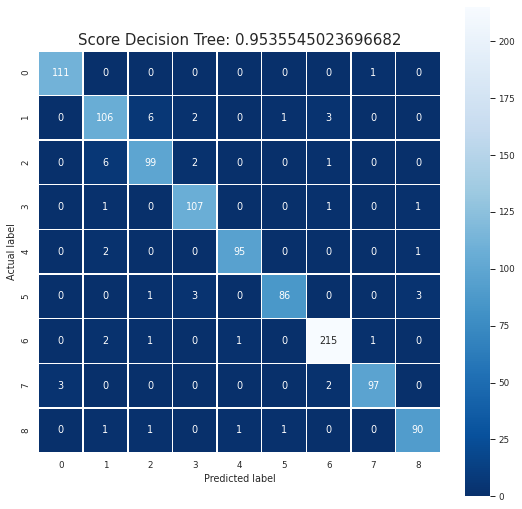

In [58]:
confusionMatrix(cm3, score3, "Score Decision Tree")

#### Conclusão melhor modelo

Após as analises apresentadas acima, podemos observar que o modelo mais coerente no conjunto de testes é o SVC que apresentou uma acuracia muito alta(mais alta entre os 3) que pode ser conferida pelas muito poucas detecções erradas apresentadas na matriz de confusão.

### Teste extra nos dados do sklearn
Como ja justificado mais acima, optamos por importar os dados direto da fonte em vez de utilizar os importados no sklearn. Mas abaixo é apresentado um teste com o mesmo como forma de comparação. E pode-se observar que aplicando o metodo SVC(nosso melhor modelo), se obtem resultados bastante semelhantes de acuracia. Como o dataset nesse caso é menor ainda, observamos uma acuracia um pouco menor mas olhando para a matriz, podemos perceber que se trata quase que de uma matriz diagonal, com muitos poucos termos diferentes de 0 fora da diagonal principal.

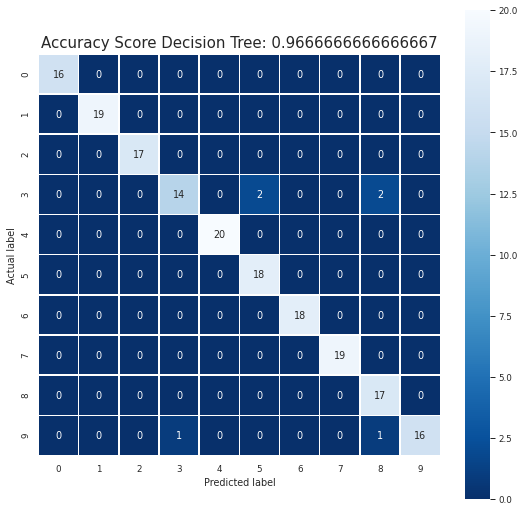

In [59]:
model2SK = SVC(kernel = 'linear', max_iter=2000, probability=False, C=1)
model2SK.fit(dfTrainDataSK, dfTrainLabelSK)

resultTest2SK = model2SK.predict(dfTestDataSK)
score2SK = model2SK.score(dfTestDataSK, dfTestLabelSK)

cm2SK = metrics.confusion_matrix(dfTestLabelSK, resultTest2SK)
confusionMatrix(cm2SK, score2SK, "Accuracy Score Decision Tree")